In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

# Download points

In [50]:
byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')

In [51]:
byrd_bedmap_points["t"].describe()

count    465760.000000
mean       1583.798401
std         567.502192
min           0.000000
25%        1235.620000
50%        1627.690000
75%        1960.980000
max        3620.100000
Name: t, dtype: float64

In [42]:
byrd_bedmap_points["source"].value_counts()

NASA_2011_ICEBRIDGE_AIR_BM2.csv    315520
UTIG_2010_ICECAP_AIR_BM3.csv        97702
NASA_2017_ICEBRIDGE_AIR_BM3.csv     27877
NASA_2013_ICEBRIDGE_AIR_BM3.csv     15628
BAS_2007_AGAP_AIR_BM2.csv            8208
LDEO_2015_ROSETTA_AIR_BM3.csv         631
BEDMAP1_1966-2000_AIR_BM1.csv         193
UTIG_2004_AGASEA_AIR_BM2.csv            1
Name: source, dtype: int64

# Download map

In [7]:
path_to_file_server = 'data/byrd_bedmachine.nc'
byrd_bedmachine = xr.open_dataset(path_to_file_server)

## Define bed topography map from Bedmachine

In [12]:
cvals  = [-2000, -1500, -1000, -500, -1,
           0, 
          1, 250, 500, 750, 1000]

colors = ["#001079", "#0023c1", "#006cef", "#47bdfc", "#bee6fa", 
          "#7eb3a1",
          "#2D6E2A", "#DFFBBC", "#AFAD48", "#7D5F18", "#481B02"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

bedmachine_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

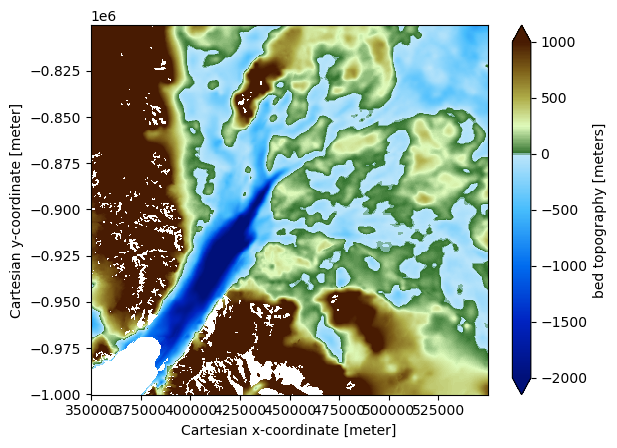

In [13]:
byrd_bedmachine.bed.plot(cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Overlay with data points

- If we see stripes in this the interpolation is inconsistent with the data
- However here we are showing Bedmachine grid and Bedmap measurements

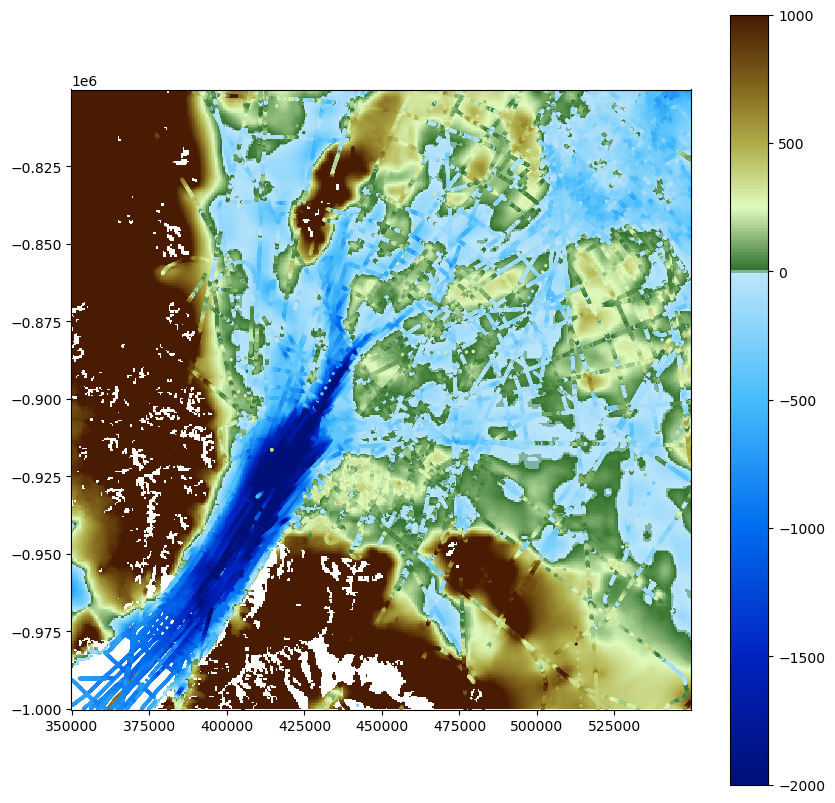

In [26]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.bed, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Plot data points
ax.scatter(byrd_bedmap_points["x"], byrd_bedmap_points["y"], 
           c = byrd_bedmap_points["b"], 
           s = 2,
           cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

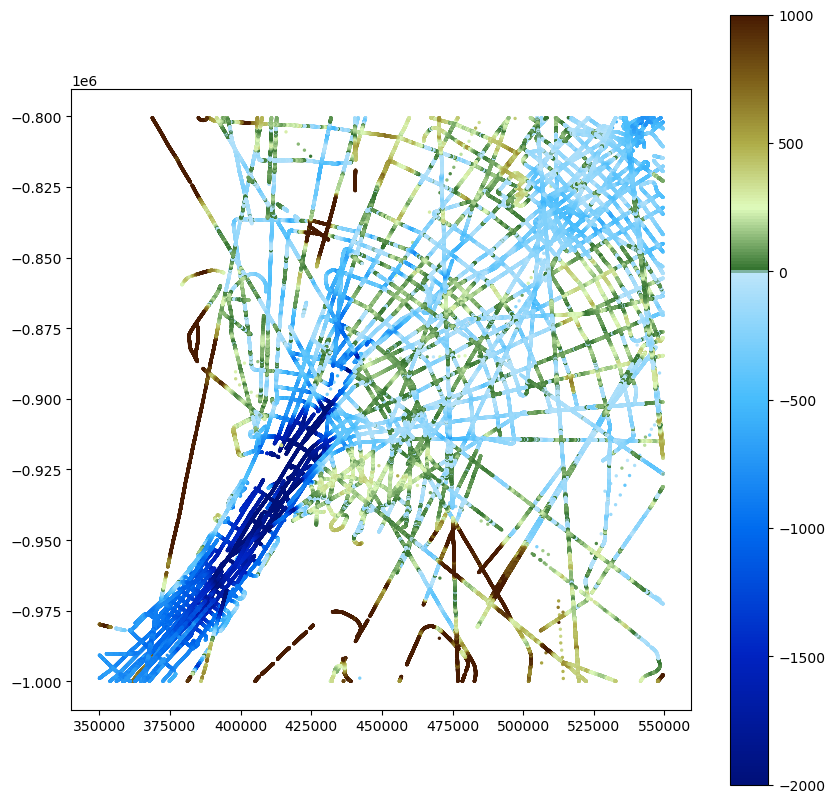

In [27]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
# ax.pcolormesh(XX, YY, byrd_bedmachine.bed, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Plot data points
# defaukt size is 20
ax.scatter(byrd_bedmap_points["x"], byrd_bedmap_points["y"], c = byrd_bedmap_points["b"], s = 2, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# White overlay just to show where we have data

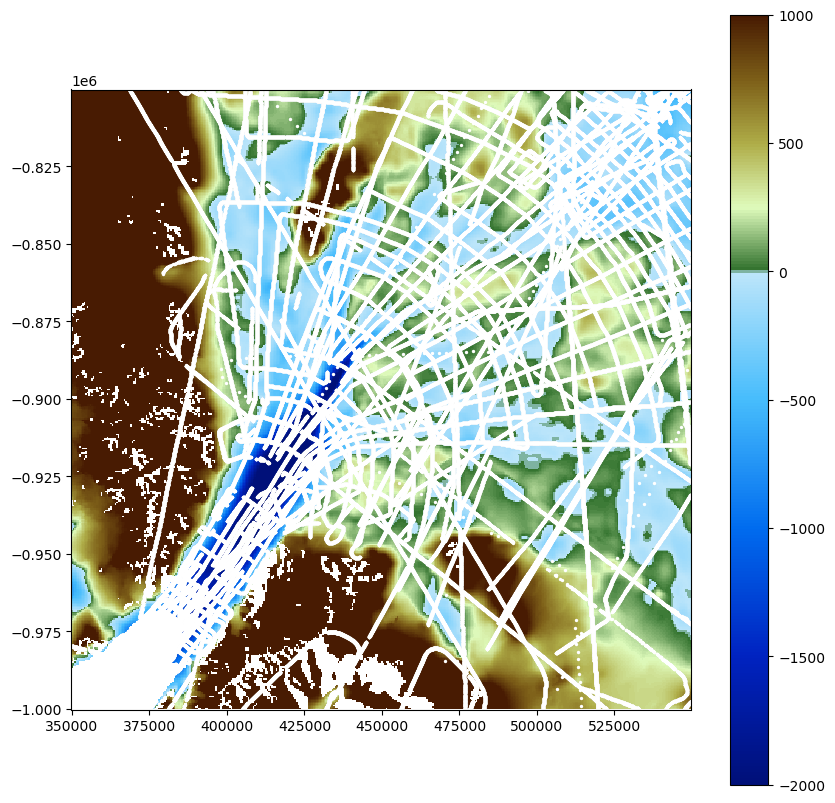

In [25]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.bed, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Plot data points
ax.scatter(byrd_bedmap_points["x"], byrd_bedmap_points["y"], 
           c = "white",
           s = 2)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Repeat for ice thickness

In [28]:
cvals  = [0, 
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

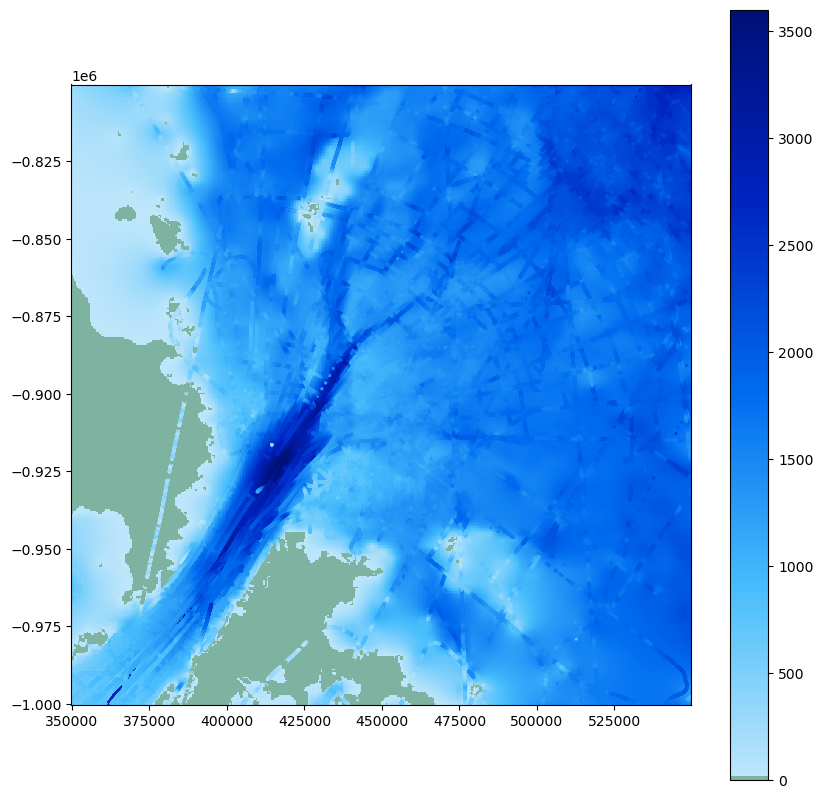

In [40]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness, cmap = icethickness_cmap, vmin = 0, vmax = 3600)

# Plot data points
ax.scatter(byrd_bedmap_points["x"], byrd_bedmap_points["y"], 
           c = byrd_bedmap_points["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3620)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Subset smaller area to see pixels

In [67]:
# Edge of ice stream
x_min = 375000 + 500
x_max = 400000

y_min = -900000 + 500
y_max = -975000

In [81]:
# Island (interesting)
x_min = 420000 + 500
x_max = 445000

y_min = -850000 + 500
y_max = -825000

In [86]:
# Narrow stream
x_min = 420000 + 500
x_max = 445000

y_min = -900000 + 500
y_max = -875000

In [87]:
byrd_bedmap_points_zoom = byrd_bedmap_points[
    (byrd_bedmap_points["x"] > x_min) & 
    (byrd_bedmap_points["x"] < x_max) & 
    (byrd_bedmap_points["y"] > y_min) & 
    (byrd_bedmap_points["y"] < y_max)]

byrd_bedmap_points_zoom

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
67,67,153.523000,-80.910000,441221.317948,-885843.398034,1165.00,1003.00,162.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
68,68,153.402600,-80.897800,443678.914546,-886106.750572,1191.00,905.00,286.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
134,134,153.177400,-80.978390,443183.389487,-876494.750747,1332.00,1033.00,299.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
135,135,153.304700,-80.964800,441902.216172,-878804.339821,1288.00,954.00,334.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
136,136,153.790200,-80.915800,436805.373245,-887322.585003,1126.00,1627.00,-501.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
...,...,...,...,...,...,...,...,...,...,...
443697,443697,153.687119,-80.881028,440085.944673,-889942.488152,992.18,1104.19,-112.01,False,UTIG_2010_ICECAP_AIR_BM3.csv
443698,443698,153.687639,-80.881209,440069.097306,-889928.746111,922.28,1083.80,-161.52,False,UTIG_2010_ICECAP_AIR_BM3.csv
443699,443699,153.688180,-80.881397,440051.584873,-889914.479200,990.69,1130.84,-140.15,False,UTIG_2010_ICECAP_AIR_BM3.csv
443700,443700,153.688699,-80.881578,440034.753625,-889900.729014,961.16,1104.61,-143.45,False,UTIG_2010_ICECAP_AIR_BM3.csv


In [88]:
byrd_bedmachine_zoom = byrd_bedmachine.sel(y = slice(y_max, y_min),
                                        x = slice(x_min, x_max))

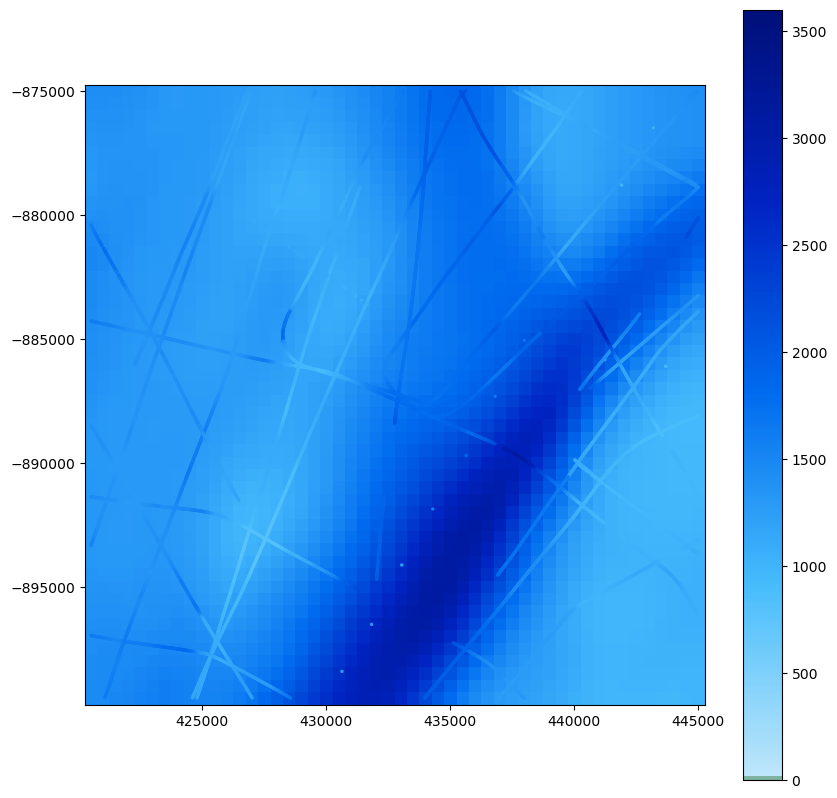

In [89]:
XX, YY = np.meshgrid(byrd_bedmachine_zoom.x, byrd_bedmachine_zoom.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine_zoom.thickness, cmap = icethickness_cmap, vmin = 0, vmax = 3600)

# Plot data points
ax.scatter(byrd_bedmap_points_zoom["x"], byrd_bedmap_points_zoom["y"], 
           c = byrd_bedmap_points_zoom["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3620)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

Observation: Single value clearly looks like an error